In [43]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt

In [ ]:
def pendulum_KE(qd):
    # Constants
    m = 1.0  # mass of the pendulum
    l = 1.0  # length of the pendulum
    g = 9.81  # acceleration due to gravity
    # Kinetic energy formula for a pendulum
    # KE = 0.5 * m * (l * qd)^2
    KE = 0.5 * m * (l * qd)**2
    return KE

def pendulum_PE(q):
    # Constants
    m = 1.0  # mass of the pendulum
    l = 1.0  # length of the pendulum
    g = 9.81  # acceleration due to gravity
    # Potential energy formula for a pendulum
    # PE = m * g * (l - l * cos(q))
    PE = m * g * l * (1 - torch.cos(q))
    return PE

def pendulum_lagrangian(q, qd):
    # Lagrangian is the difference between kinetic and potential energy
    return pendulum_KE(qd) - pendulum_PE(q)

def lagrangian_dynamics(x, Lagrangian):
    # derives the dynamics using just state information

    # d/dt(dL/dqd) - dL/dq = 0
    # d2L/dqd2 * qdd + d/dq(dL/dqd) * qd = dL/dq
    # qdd = (dL_dq - d/dq(dL/dqd) * qd) / d2L_dqd2
    # qdd = (G - C*qd) / M

    q = x[:, 0]
    qd = x[:, 1]

    L:torch.Tensor = Lagrangian(q, qd)

    G, = grad(L.sum(), q, create_graph=True, allow_unused=True)
    dLdqd, = grad(L.sum(), qd, create_graph=True, allow_unused=True)
    M, = grad(dLdqd.sum(), qd, create_graph=True, allow_unused=True)
    C, = grad(dLdqd.sum(), q, create_graph=True, allow_unused=True, materialize_grads=True)

    qdd = (G - C * qd) / M
    return torch.hstack([qd.unsqueeze(1), qdd.unsqueeze(1)])

def rk4_step(func, x, dt):
    k1 = func(x)
    k2 = func(x + 0.5 * dt * k1)
    k3 = func(x + 0.5 * dt * k2)
    k4 = func(x + dt * k3)
    return x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

batch_size = 10  # example batch size
x0 = torch.tensor([[torch.pi / i, 0.0] for i in range(2,21)], requires_grad=True)  # initial state for each batch
t0 = 0.0  # initial time
t1 = 20.0  # final time
dt = 0.01  # time step
num_steps = int((t1 - t0) / dt)

# store traj
xs = []

for i in range(num_steps):
    t = t0 + i * dt

    x0 = rk4_step(lambda x: lagrangian_dynamics(x, pendulum_lagrangian), x0, dt)

    xs.append(x0.clone().detach())
    if i % 100 == 0:  # print every 100 steps
        print(f"Step {i}: t = {t}")


Step 0: t = 0.0
Step 100: t = 1.0
Step 200: t = 2.0
Step 300: t = 3.0
Step 400: t = 4.0
Step 500: t = 5.0
Step 600: t = 6.0
Step 700: t = 7.0
Step 800: t = 8.0
Step 900: t = 9.0
Step 1000: t = 10.0
Step 1100: t = 11.0
Step 1200: t = 12.0
Step 1300: t = 13.0
Step 1400: t = 14.0
Step 1500: t = 15.0
Step 1600: t = 16.0
Step 1700: t = 17.0
Step 1800: t = 18.0
Step 1900: t = 19.0


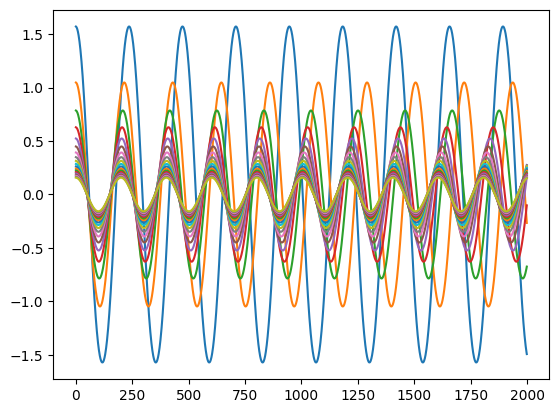

In [109]:
xp = torch.stack(xs, dim=0)
plt.figure()
plt.plot(xp[:,:,0])